In [ ]:
!pip install arff
!pip install tensorflow

  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4970 sha256=abb2dc1bd38150718f9398dde146aca3fd21951c60ad82a157b6cb38e6c94267
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
dataFrame=pd.read_csv('meteorological_data.csv')
dataFrame.head(5)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.67261,29.55,49,2003-02-18,28.15,2.815185,2.158130
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.67261,29.55,50,2003-02-19,27.90,4.412632,4.312026
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.67261,29.55,51,2003-02-20,25.85,2.939072,3.032922
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.67261,29.55,52,2003-02-21,26.40,4.719712,4.768149
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.67261,29.55,53,2003-02-22,27.70,4.333662,4.317706


In [ ]:
drop_columns=['altura','longitude','latitude','RADIACAO GLOBAL(Kj/m²)','VENTO, VELOCIDADE HORARIA(m/s)']

dataFrame=dataFrame.drop(labels=drop_columns,axis=1)
display(dataFrame)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)",dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO
0,29.6,84.0,26.7,68.0,1008.690909,77.636364,49,2003-02-18,28.15,2.815185,2.158130
1,31.5,95.0,24.3,62.0,1008.700000,80.750000,50,2003-02-19,27.90,4.412632,4.312026
2,27.6,95.0,24.1,78.0,1008.354167,88.333333,51,2003-02-20,25.85,2.939072,3.032922
3,30.8,96.0,22.0,61.0,1008.354167,83.083333,52,2003-02-21,26.40,4.719712,4.768149
4,31.2,94.0,24.2,59.0,1008.283333,82.041667,53,2003-02-22,27.70,4.333662,4.317706
...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,988.400000,33.500000,339,2019-12-05,34.25,4.155351,3.864984
65719,37.6,33.0,34.7,28.0,985.700000,29.000000,341,2019-12-07,36.15,3.246348,2.578275
65720,34.9,67.0,29.4,40.0,988.720000,51.200000,342,2019-12-08,32.15,4.138430,3.941287
65721,35.1,76.0,26.6,36.0,989.040000,45.400000,343,2019-12-09,30.85,5.009957,4.618717


# **Splitting the data**

Split the data into training and testing based on the data dates. The data dated between  2003-02-18 and 2019-06-01 from each weather station goes to the training group and the rest goes to the test group. the manner to divide data depends on context. In this situation, the Eo can be more easily predicted using future data, causing a methodological error. So you need to split the data that way.

In [ ]:
name_empirical_model=['Eo_samani']
empirical_model=[]

dataFrame['data completa'] = pd.to_datetime(dataFrame['data completa'])
dataFrame = dataFrame.set_index(dataFrame['data completa'])
dataFrame = dataFrame.sort_index()

train_dataset = dataFrame['2003-02-18	':'2019-06-01']
test_dataset  = dataFrame['2019-06-01':]

test_date=test_dataset.index

train_labels = train_dataset.loc[:,'Eo_FAO']
test_labels = test_dataset.loc[:,'Eo_FAO']

empirical_model=test_dataset.loc[:,name_empirical_model]

train_dataset=train_dataset.drop(labels=name_empirical_model,axis=1)
test_dataset=test_dataset.drop(labels=name_empirical_model,axis=1)

train_dataset=train_dataset.drop(labels=['data completa'],axis=1)
test_dataset=test_dataset.drop(labels=['data completa'],axis=1)

In [ ]:
display(test_date)

DatetimeIndex(['2019-06-01', '2019-06-01', '2019-06-01', '2019-06-01',
               '2019-06-01', '2019-06-01', '2019-06-01', '2019-06-01',
               '2019-06-01', '2019-06-01',
               ...
               '2021-11-24', '2021-11-24', '2021-11-24', '2021-11-24',
               '2021-11-25', '2021-11-25', '2021-11-25', '2021-11-25',
               '2021-11-25', '2021-11-25'],
              dtype='datetime64[ns]', name='data completa', length=8544, freq=None)

In [ ]:
plt.hist(train_dataset['altura'])
plt.ylabel('quantidade')
plt.xlabel('Eo classes')
plt.title('Histograma da Evapotranspiração de referencia')
plt.grid(True)
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(train_dataset)
normed_train_data=pd.DataFrame(scaler.transform(train_dataset))
scaler.fit(test_dataset)
normed_test_data=pd.DataFrame(scaler.transform(test_dataset))
normed_train_data=normed_train_data.drop(labels=[len(normed_test_data.columns)-1],axis=1)
normed_test_data=normed_test_data.drop(labels=[len(normed_test_data.columns)-1],axis=1)  

In [ ]:
display(normed_test_data,len(dataFrame.columns))

,0,1,2,3,4,5,6,7
0,-0.161158,0.434451,-0.298595,-0.308025,0.145847,0.156680,-0.425576,-0.260941
1,0.025174,-0.082318,0.294637,-0.110899,0.131697,0.077254,-0.425576,0.165570
2,-2.614529,1.381860,-1.569805,2.320326,-2.406410,2.006175,-0.425576,-2.585425
3,0.428894,0.348323,-0.976574,-0.636569,-0.622843,-0.214921,-0.425576,-0.196964
4,-0.316434,0.606707,-0.171474,0.940442,1.014047,0.860169,-0.425576,-0.303592
...,...,...,...,...,...,...,...,...
8539,-0.067992,-3.355185,3.472663,-0.308025,0.055923,-2.084273,1.295884,1.701009
8540,1.174222,-0.426830,0.887868,-0.636569,-0.242454,-0.714171,1.295884,1.253173
8541,0.677336,0.003810,0.125142,-0.965113,0.055978,-0.862966,1.295884,0.528104
8542,-0.067992,-0.426830,1.565847,0.611898,0.902060,0.185046,1.295884,0.741360


11

# **Making the prediction to estimate Eo by Neural Network.**

In [ ]:
#criando a rede neural 2 camadas escondidas com 5 neuronios cada usando a função de ativação relu.
def constroi_modelo(train):

  model = keras.Sequential([
    layers.Dense(5, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model=constroi_modelo(normed_train_data)

history = model.fit(
    x=normed_train_data,
    y=train_labels,
    epochs=300,
    validation_split=0.2,
    verbose=2
)



Epoch 1/300
1430/1430 - 2s - loss: 4.8365 - mae: 1.5068 - mse: 4.8365 - val_loss: 0.2259 - val_mae: 0.3521 - val_mse: 0.2259 - 2s/epoch - 1ms/step
Epoch 2/300
1430/1430 - 2s - loss: 0.1112 - mae: 0.2534 - mse: 0.1112 - val_loss: 0.1519 - val_mae: 0.2943 - val_mse: 0.1519 - 2s/epoch - 1ms/step
Epoch 3/300
1430/1430 - 2s - loss: 0.0845 - mae: 0.2269 - mse: 0.0845 - val_loss: 0.1296 - val_mae: 0.2671 - val_mse: 0.1296 - 2s/epoch - 1ms/step
Epoch 4/300
1430/1430 - 2s - loss: 0.0742 - mae: 0.2115 - mse: 0.0742 - val_loss: 0.1131 - val_mae: 0.2492 - val_mse: 0.1131 - 2s/epoch - 1ms/step
Epoch 5/300
1430/1430 - 2s - loss: 0.0652 - mae: 0.1972 - mse: 0.0652 - val_loss: 0.1058 - val_mae: 0.2409 - val_mse: 0.1058 - 2s/epoch - 1ms/step
Epoch 6/300
1430/1430 - 1s - loss: 0.0553 - mae: 0.1809 - mse: 0.0553 - val_loss: 0.0894 - val_mae: 0.2216 - val_mse: 0.0894 - 1s/epoch - 1ms/step
Epoch 7/300
1430/1430 - 2s - loss: 0.0480 - mae: 0.1681 - mse: 0.0480 - val_loss: 0.0766 - val_mae: 0.2050 - val_mse: 

In [ ]:
historico = pd.DataFrame(history.history)
historico['epoch'] = history.epoch
historico.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,0.027413,0.126852,0.027413,0.048611,0.165039,0.048611,295
296,0.027424,0.126976,0.027424,0.050151,0.167059,0.050151,296
297,0.027487,0.126933,0.027487,0.058281,0.180535,0.058281,297
298,0.027510,0.127038,0.027510,0.050801,0.169402,0.050801,298
299,0.027492,0.126794,0.027492,0.054234,0.176034,0.054234,299


In [ ]:
previsoes_teste = model.predict(normed_test_data).flatten()
previsoes_teste=pd.Series(previsoes_teste)

0       4.607298
1       4.486299
2       3.085051
3       5.347442
4       4.345123
          ...   
8539    2.599051
8540    5.690160
8541    5.639565
8542    3.997188
8543    5.522032
Length: 8544, dtype: float32 0       4.405768
1       4.153256
2       2.960670
3       5.132889
4       4.605365
          ...   
8539    1.522445
8540    5.812633
8541    5.834698
8542    4.084357
8543    5.621518
Name: Eo_FAO, Length: 8544, dtype: float64


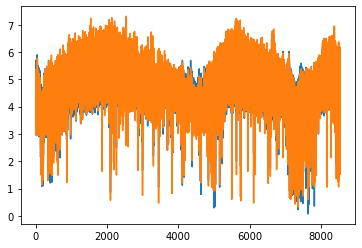

In [ ]:
print(previsoes_teste,test_labels.reset_index(drop=True))

plt.plot(previsoes_teste)
plt.plot(test_labels.reset_index(drop=True))

plt.savefig('result.png')
plt.show()


The first test using only 3 climatic features: 	TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)	TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)	and temperatura media

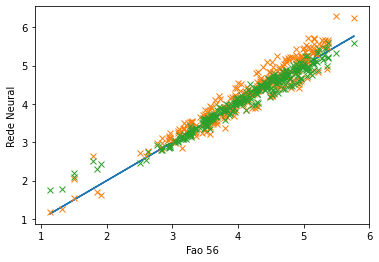

0.8761350112742727 0.9297759143735504


In [ ]:
plt.plot(test_labels[0:300].reset_index(drop=True),test_labels[0:300].reset_index(drop=True))
plt.plot(test_labels[0:300].reset_index(drop=True),previsoes_teste[0:300],'x')
plt.plot(test_labels[0:300].reset_index(drop=True),empirical_model[0:300],'x')
plt.ylabel('Rede Neural')
plt.xlabel('Fao 56')
#plt.plot(previsoes_teste[0:50])
plt.savefig('grap.png')
plt.show()
r2=r2_score(test_labels, previsoes_teste)
r2_2=r2_score(test_labels, empirical_model)
print(r2,r2_2)

The first test using only 4 climatic features: TEMPERATURA MAXIMA NA HORA ANT., UMIDADE REL. MAX. NA HORA ANT. (AUT)(%), (AUT)(°C) TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C), UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)

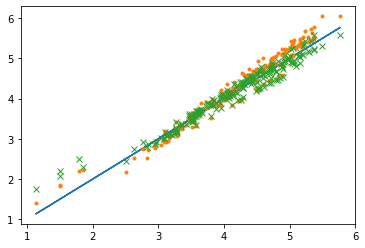

0.9332059316569158
0.9297759143735504


In [ ]:
plt.plot(test_labels[0:200].reset_index(drop=True),test_labels[0:200].reset_index(drop=True))
plt.plot(test_labels[0:200].reset_index(drop=True),previsoes_teste[0:200],'.')
plt.plot(test_labels[0:200].reset_index(drop=True),empirical_model[0:200],'x')
#plt.plot(previsoes_teste[0:50])
plt.savefig('grap.png')
plt.show()
r2=r2_score(test_labels, previsoes_teste)
r2_2=r2_score(test_labels, empirical_model)
print(r2)
print(r2_2)

The first test using 7 climatic features: TEMPERATURA MAXIMA NA HORA ANT., UMIDADE REL. MAX. NA HORA ANT. , TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C), UMIDADE REL. MIN. NA HORA ANT.  PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO HORARIA(mB),	UMIDADE RELATIVA DO AR and temperatura media

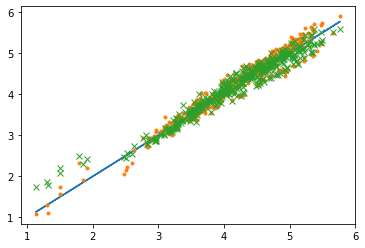

0.9409936132961398
0.9297759143735504


In [ ]:
plt.plot(test_labels[0:400].reset_index(drop=True),test_labels[0:400].reset_index(drop=True))
plt.plot(test_labels[0:400].reset_index(drop=True),previsoes_teste[0:400],'.')
plt.plot(test_labels[0:400].reset_index(drop=True),empirical_model[0:400],'x')
#plt.plot(previsoes_teste[0:50])
plt.savefig('grap.png')
plt.show()
r2=r2_score(test_labels, previsoes_teste)
r2_2=r2_score(test_labels, empirical_model)
print(r2)
print(r2_2)